# Hello Neighbour!
Kornpob Bhirombhakdi

## Problems & Significance
Knowing the distribution of the socioeconomic status, and the current consumer behaviour is always the biggest challenge in any business. These factors affect decision making, policy planning, and determine the odds of success. **"Hello Neighbour!" will be the solution.**

## Data
**Hello Neighbour!** analyzed the distribution of the socioeconomic status and consumer behaviour on US population by using data from a Census Block Group (CBG) survey, which is the most granular level the US Census Bureau reports data on.

The dataset was acquired from Kaggle (https://www.kaggle.com/safegraph/census-block-group-american-community-survey-data/home), which included CBG-level data from the American Community Survey (2016) joined with the visit and consumer behavioural CBG-level data from SafeGraph (https://docs.safegraph.com/docs) conducted during 1st October--November 2018.

The size of dataset is about **8GB (unzipped)** containing more than 10 data tables, one GEOJSON file with the polygons for all CBGs, and some metadata files.

## Preliminaries

The dataset is very rich, and is very potential for providing insight to many questions. The following analysis presented some interesting features, in order to demonstrated what implications the data could bring.

In [78]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

### Where should the location of our new business be?

We might wonder about where the location of our new business should be to optimize the chance of being seen/visited. To answer this, knowing how the travelling behaviour of the population is one of the keys, and the dataset can provide us this insight. Here is how the data looks like.

In [22]:
dat = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\data\cbg_patterns.csv", dtype='str')
dat = dat[~dat['census_block_group'].isna()]

In [23]:
dat.columns

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')

In [24]:
dat.head(2)

,census_block_group,date_range_start,date_range_end,raw_visit_count,raw_visitor_count,visitor_home_cbgs,visitor_work_cbgs,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,popularity_by_hour,popularity_by_day
0,010059508001,1538352000,1541030400,75122,18314,"{""010059501003"":127,""010059509001"":111,""010059...","{""010059501003"":109,""010810407002"":62,""0108104...",194724,"[""Chick-fil-A"",""mcdonalds"",""Marathon Petroleum...","[""walmart"",""mcdonalds"",""Dollar General"",""Chick...","[""CrossFit"",""Health Mart"",""Coldwell Banker""]","[2617,2457,2403,2519,2646,3007,3886,7566,5508,...","{""Monday"":12000,""Tuesday"":12224,""Wednesday"":10..."
1,010090506011,1538352000,1541030400,95649,38942,"{""010730113021"":210,""010090506022"":205,""010090...","{""010890111001"":271,""010730045001"":269,""010439...",120587,"[""Shell Oil"",""mcdonalds"",""Chick-fil-A"",""Chevron""]","[""walmart"",""mcdonalds"",""Shell Oil"",""Chick-fil-...",[],"[6556,6325,6222,6355,6586,7350,8568,8099,7378,...","{""Monday"":12125,""Tuesday"":12984,""Wednesday"":12..."


Notice the **'distance_from_home'** column. It measured the median distance from home traveled to the CBG by visitors in meters. (Note: 1 meter ~ 6.21371e-4 mile)

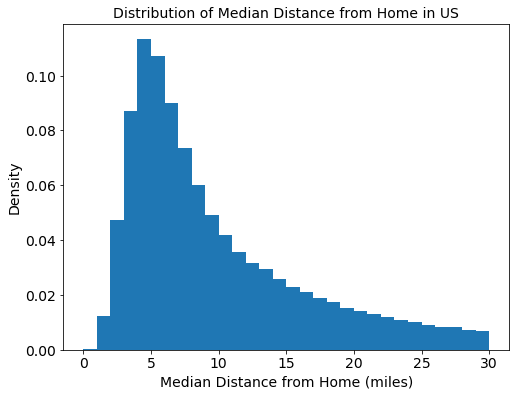

In [25]:
plt.figure(figsize=(8,6))
plt.hist((dat['distance_from_home'].dropna().astype('float') * 6.21371e-4).compute()
         , bins=np.arange(31), density=True
        )
plt.title('Distribution of Median Distance from Home in US', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Median Distance from Home (miles)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [27]:
x = (dat['distance_from_home'].dropna().astype('float') * 6.21371e-4).describe().compute()
print(tabulate([tuple(list(x.values))], headers=x.index, tablefmt='grid'))

+---------+---------+---------+----------+---------+---------+---------+--------+
|   count |    mean |     std |      min |     25% |     50% |     75% |    max |
+=========+=========+=========+==========+=========+=========+=========+========+
|  220518 | 21.8181 | 61.9705 | 0.438688 | 5.40406 | 9.23823 | 19.6712 | 3913.3 |
+---------+---------+---------+----------+---------+---------+---------+--------+


The data implied that about 50% of the population travelled less than 9 miles in a day, with the mode at about 5 miles. Therefore, **setting up a new business within 9 miles radius from the residential area should be considered.** We note that this analysis aggregated every CBG as one population. Difference between sub-population such as rural compared to urban area would provide better insight, and can be analyzed from the dataset.

### When should the operation hours be?

In order to optimize the yields, some businesses might be flexible to design their own operation hours. Therefore, knowing how the area is populated through the week is valuable.

In [29]:
dat.columns

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')

We demonstrated how to answer this question by looking at **'popularity_by_day'** which measured the counts of visits on each day at the CBG.

In [30]:
x = dat['census_block_group'].compute()
x = x.str.extract('(..)(...)(......)(.)')
y = dat['popularity_by_day'].compute()
x['popularity_by_day'] = y
subdat = x.copy()
subdat.reset_index(drop=True,inplace=True)

# SS=36 for New York
# New York County/Manhattan 061, Kings County/Brooklyn 047, Queens County/Queens 081
ss = ['36']
ccc = ['061','047','081','003']
records = {}
for i in ss:
    for j in ccc:
        x = subdat[subdat[0]==i]
        x = x[x[1]==j]
        z = np.zeros(7)
        for k in x.index:
            try:
                y = x['popularity_by_day'].loc[k]
                z = z + np.array(list(ast.literal_eval(y).values()))
            except:
                print(y)
                print('Skip: {0}{1} {2}'.format(i,j,k))
        records[i+j] = z

{}
Skip: 36081 220675
{}
Skip: 36003 220633


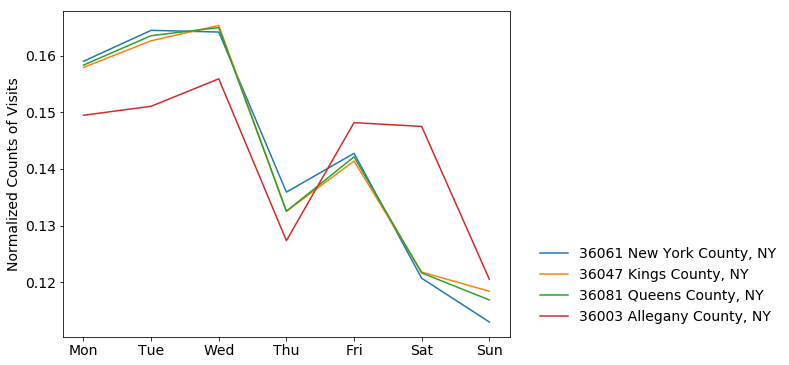

In [31]:
plt.figure(figsize=(8,6))
x = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
lab = {'36061': 'New York County, NY', '36047': 'Kings County, NY', '36081': 'Queens County, NY', '36003': 'Allegany County, NY'}
for i in records.keys():
    plt.plot(x,records[i]/np.sum(records[i]),label='{} {}'.format(i,lab[i]))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Normalized Counts of Visits', fontsize=14)
plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=14, frameon=False)
plt.show()

The plot showed the trends of visits of 4 counties in NY: New York County, Kings County, Queens County, and Allegany County. The first three counties are considered urban, compared to the last one. As we can see, the visits were more frequent during the early of the week: Monday to Wednesday. Then, it plunged down on Thursday before climbing up again on Friday. **Saturday in Allegany tended to be busier than the urban areas**, while Sunday should be avoided for running a business.

### How is the competition in the area?

The competition analysis is important at every stage of a business. One valuable information we can get from the dataset is the counts of visits to various brands in each CBGs.

In [32]:
dat.columns

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')

In this analysis, we demonstrated with the **'top_brands'** visited during the time period.

In [33]:
x = dat['census_block_group'].compute()
x = x.str.extract('(..)(...)(......)(.)')
y = dat['top_brands'].compute()
x['top_brands'] = y
subdat = x.copy()

#39 = OH
ss = ['36','39']
records = {}
for i in ss:
    x = subdat[subdat[0]==i]
    y = []
    for j in x['top_brands']:
        z = ast.literal_eval(j)
        for k in z:
            y.append(k)
    y = pd.Series(y)
    records[i] = y.value_counts()

In [34]:
ranks = {}
for i in records.keys():
    x = records[i]
    x = x.to_frame()
    x.reset_index(drop=False,inplace=True)
    x.sort_values(by=[0],ascending=False,inplace=True)
    y = x.iloc[0:5]
#     z = {'index': 'Others', 0: np.sum(x[0].iloc[5:])}
#     z = pd.DataFrame([z])
#     y = pd.concat([y,z])
    y.reset_index(drop=True,inplace=True)
    y.columns = ['top_brands','counts']
    ranks[i] = y

In [35]:
a = {'36': 'NY', '39': 'OH'}
for i in ranks.keys():
    print('State: {0} \nUnits: Counts'.format(a[i]))
    print(tabulate([tuple(list(ranks[i]['counts'].values))], headers=ranks[i]['top_brands'], tablefmt='grid'))
    print('\n')

State: NY 
Units: Counts
+---------------------------------------+------------------+----------+----------+--------------------+
|   United States Postal Service (USPS) |   Dunkin' Donuts |   SUBWAY |   Sunoco |   Cricket Wireless |
+=======================================+==================+==========+==========+====================+
|                                  1347 |             1229 |      791 |      695 |                598 |
+---------------------------------------+------------------+----------+----------+--------------------+


State: OH 
Units: Counts
+---------------------------------------+----------+------------------+----------------------+-------------+
|   United States Postal Service (USPS) |   SUBWAY |   Dollar General |   Marathon Petroleum |   mcdonalds |
+=======================================+==========+==================+======================+=============+
|                                   897 |      778 |              706 |                  659 |       

The analysis demonstrated the five most visited brands in NY and OH. Let's say, we would like to run a donut shop. **Opening a new donut shop in NY would be more challenging than in OH**.

### What is the income distribution?

Socioeconomic factors affect the choices of consumption. A successful business is the one which provides products matched with the demands given these underlying factors. Price, or the invisible hand, plays the most important role determining this, and every business must be precautious about.

There are several methods to estimate the price of a product. With the data we have, we can get insight in several aspects. One thing we can learn was to know the income distribution, so that we can lauch a product that its **price is appropiate to the income level**.

In [36]:
dat2 = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\data\cbg_b19.csv", dtype='str').compute()
colname = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\metadata\cbg_field_descriptions.csv", dtype='str').compute()

In [37]:
dat2.columns

Index(['census_block_group', 'B19001e1', 'B19001m1', 'B19001e2', 'B19001m2',
       'B19001e3', 'B19001m3', 'B19001e4', 'B19001m4', 'B19001e5',
       ...
       'B19313Ee1', 'B19313Em1', 'B19313Fe1', 'B19313Fm1', 'B19313Ge1',
       'B19313Gm1', 'B19313He1', 'B19313Hm1', 'B19313Ie1', 'B19313Im1'],
      dtype='object', length=401)

In [38]:
dat2.head(2)

,census_block_group,B19001e1,B19001m1,B19001e2,B19001m2,B19001e3,B19001m3,B19001e4,B19001m4,B19001e5,...,B19313Ee1,B19313Em1,B19313Fe1,B19313Fm1,B19313Ge1,B19313Gm1,B19313He1,B19313Hm1,B19313Ie1,B19313Im1
0,010010201001,284,53,24,29,33,25,23,22,25,...,NaN,NaN,NaN,NaN,NaN,NaN,13071500,4351307,NaN,NaN
1,010010201002,456,64,8,10,15,24,14,22,5,...,NaN,NaN,NaN,NaN,932100,777912,35555700,10801102,NaN,NaN


In [39]:
colname.columns

Index(['table_id', 'field_full_name', 'field_level_1', 'field_level_2',
       'field_level_3', 'field_level_4', 'field_level_5', 'field_level_6',
       'field_level_7', 'field_level_8'],
      dtype='object')

In [40]:
colname.head(2)

,table_id,field_full_name,field_level_1,field_level_2,field_level_3,field_level_4,field_level_5,field_level_6,field_level_7,field_level_8
0,B00001e1,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,Unweighted Sample Count Of The Population,Total,Total Population -- (Estimate),NaN,NaN,NaN,NaN,NaN
1,B00001m1,UNWEIGHTED SAMPLE COUNT OF THE POPULATION: Tot...,Unweighted Sample Count Of The Population,Total,Total Population -- (Margin Of Error),NaN,NaN,NaN,NaN,NaN


The above cells showed how the data look like. Note that we chose Table B19 because it related to the income aspects, and the column description was provided in a separated file.

The data provided different measurements related to the income of participants in each CBG. Here, for the demonstration we considered **the median household income in the past 12 months (in 2016 inflation-adjusted dollars).**

In [41]:
x = colname['field_full_name'].str.match(pat='MEDIAN HOUSEHOLD INCOME.+')
y = colname[x][['table_id','field_full_name']]
y.reset_index(drop=True,inplace=True)
y = y.iloc[0:2]
print(y['table_id'].unique())
print(y['field_full_name'].unique())

['B19013e1' 'B19013m1']
[ 'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)'
 'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Margin of Error)']


In [42]:
x = []
x = ['census_block_group']
for i in y['table_id'].unique():
    x.append(i)
z = dat2[x]
subdat = z.copy()
subdat.head(2)

,census_block_group,B19013e1,B19013m1
0,010010201001,NaN,NaN
1,010010201002,77813,11618


In [43]:
fips = {'36061': 'New York County, NY'
        , '36047': 'Kings County, NY'
        , '36081': 'Queens County, NY'
        , '36005': 'Bronx County, NY'
        , '36085': 'Richmond County, NY'}

In [44]:
x = subdat['census_block_group']
x = x.str.extract('(.....)(......)(.)')
subdat['fips'] = x[0]

In [45]:
y = list(fips.keys())
z = subdat[subdat['fips'].isin(y)]['B19013e1']

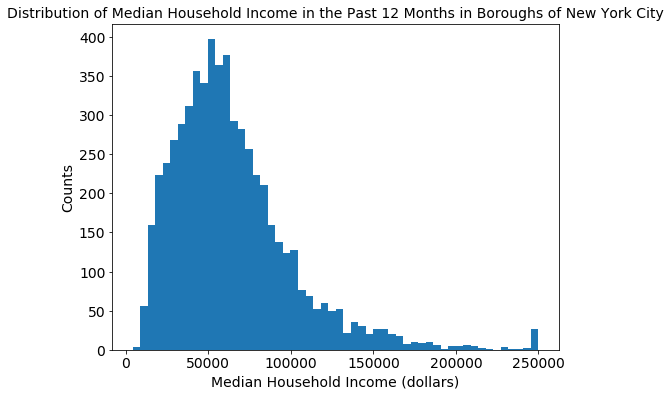

In [46]:
plt.figure(figsize=(8,6))
plt.hist(z.dropna().astype('float')
         , bins='auto'
#          , density=True
        )
plt.title('Distribution of Median Household Income in the Past 12 Months in Boroughs of New York City', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Median Household Income (dollars)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [47]:
a = z.astype('float').describe()
print('Area: Boroughs of New York City \nUnits: dollars')
print(tabulate([tuple(list(a.values))], headers=a.index, tablefmt='grid'))

Area: Boroughs of New York City 
Units: dollars
+---------+--------+---------+-------+-------+---------+---------+--------+
|   count |   mean |     std |   min |   25% |     50% |     75% |    max |
+=========+========+=========+=======+=======+=========+=========+========+
|    5856 |  64313 | 36581.6 |  4263 | 39375 | 57455.5 | 80682.8 | 250001 |
+---------+--------+---------+-------+-------+---------+---------+--------+


The data showed that the median household income of new yorkers in these areas was distributed with about \\$57k in median and \\$50k in mode. Therefore, if the business aims to target a large group of consumers in the Boroughs of New York City, **the target population with about \\$50-60k annual income would be appropriate**.

# Forecasting: available health insurance market share in young adults (18--34 years old).

This section demonstrated how a forecasting model can be developed from the CBG data. In this scenario, a health insurance business would like to **forecast the available market share** in order to strategically plan to tackle the market. Our target was **a young adult (18--34 years old) who did not have any health insurance.**

For simplicity, we will apply linear regression, logistic regression (with continuous outcomes), and neural network models with this set of variables:

- outcome: 'B27010e33' individuals age 18--34 years who had no health insurance, normalized to 'B27010e18' total individuals age 18--34 years

- input:

    - 'B15003e17', 'B15003e2', 'B15003e21', 'B15003e22', 'B15003e23', 'B15003e24', 'B15003e25' individuals age 25 years and over who attained education level regular high school/no schooling completed/associate degree/bachelor degree/master/professional degree/doctorate, normalized to 'B15003e1' total individuals age 25 years and over
    - 'B19013e1' median household income
    - 'B25002e2' occupied housing units, normalized to 'B25001e1' total housing units

In [229]:
varlist = {
           "C:\TDI\_data\safegraph_open_census_data\data\cbg_b15.csv": ['B15003e17', 'B15003e2', 'B15003e21', 'B15003e22'
                                                                        , 'B15003e23', 'B15003e24', 'B15003e25','B15003e1']
          ,"C:\TDI\_data\safegraph_open_census_data\data\cbg_b19.csv": ['B19013e1']
          ,"C:\TDI\_data\safegraph_open_census_data\data\cbg_b25.csv": ['B25002e2','B25002e1']
          ,"C:\TDI\_data\safegraph_open_census_data\data\cbg_b27.csv": ['B27010e33','B27010e18']
          }

In [230]:
for i in varlist.keys():
    try:
        dat = dd.read_csv(i, dtype='str')
        x = pd.DataFrame(dat['census_block_group'].compute())
        x[varlist[i]] = dat[varlist[i]].compute()
        x.set_index('census_block_group', inplace=True)
        try:
            subdat = subdat.join(x, how='outer')
        except:
            print('Exception subdat.join: {0}'.format(i))
            subdat = x.copy()
    except:
        print('Exception: {0}'.format(i))

Exception subdat.join: C:\TDI\_data\safegraph_open_census_data\data\cbg_b15.csv


In [236]:
subdat.dropna(inplace=True)
edu = subdat[subdat.columns[1:8]].astype('float')
income = subdat[subdat.columns[8]].astype('float')
housing = subdat[subdat.columns[9:11]].astype('float')
insurance = subdat[subdat.columns[11:]].astype('float')

In [239]:
edusc = (edu[edu.columns[0:-1]].T / edu[edu.columns[-1]]).T
edusc.dropna(inplace=True)
housingsc = (housing[housing.columns[0:-1]].T / housing[housing.columns[-1]]).T
insurancesc = (insurance[insurance.columns[0]].T / insurance[insurance.columns[1]]).T
insurancesc.name = insurance.columns[1]

In [240]:
subdatsc = edusc.copy()
subdatsc = subdatsc.join(income)
subdatsc = subdatsc.join(housingsc)
subdatsc = subdatsc.join(insurancesc)
subdatsc.dropna(inplace=True)

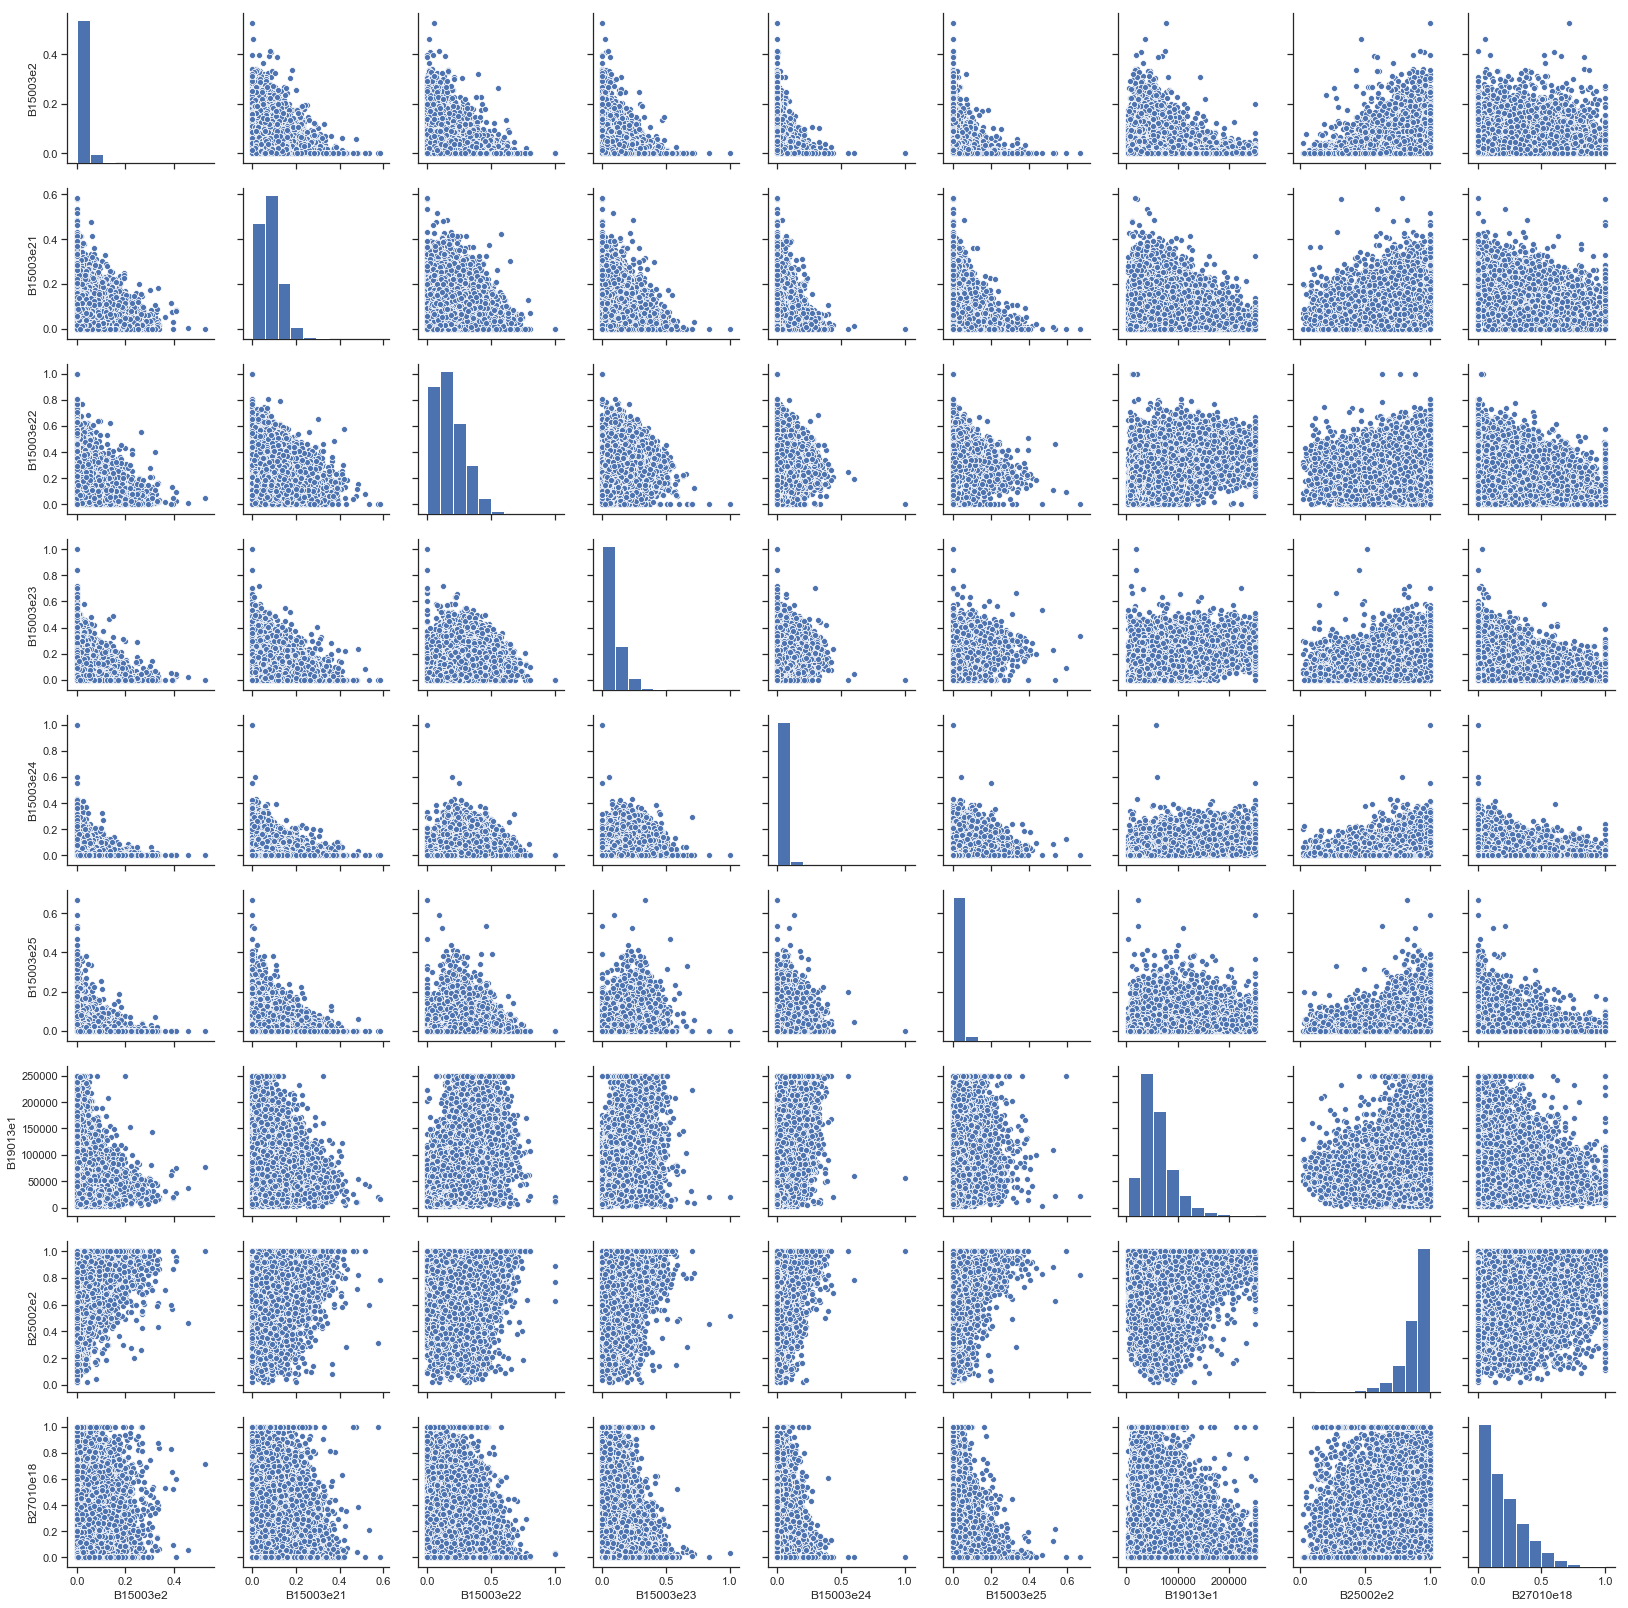

In [252]:
import seaborn as sns; sns.set(style='ticks', color_codes=True)
g = sns.pairplot(subdatsc)

The scatter plots showed the distribution of data given a single variable, and a pair of variables. We can notice the trends by looking at the density of points, which implied that the data is non-random and **there should be underlying relationships here.**

In [308]:
X = subdatsc[subdatsc.columns[0:-1]]
Y = subdatsc[subdatsc.columns[-1]]
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,random_state=1234)

In [309]:
reg = LinearRegression().fit(Xtrain,Ytrain)
print('Linear regression model')
print('Score training set: {0:.3f}'.format(reg.score(Xtrain,Ytrain)))
print('Score testing set: {0:.3f}'.format(reg.score(Xtest,Ytest)))

Linear regression model
Score training set: 0.215
Score testing set: 0.220


In [293]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrainsc = scaler.transform(Xtrain)
Xtestsc = scaler.transform(Xtest)
nn = MLPRegressor(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100,), activation='relu'
                  , learning_rate='adaptive', random_state=1234, warm_start=True)
nn.fit(Xtrainsc,Ytrain)
print('Neural network model')
print('Score training set: {0:.3f}'.format(nn.score(Xtrainsc,Ytrain)))
print('Score testing set: {0:.3f}'.format(nn.score(Xtestsc,Ytest)))

Neural network model
Score training set: 0.244
Score testing set: 0.245


In [310]:
Ytr = np.log10(Y / (1. -Y))
Ytr = Ytr[~np.isinf(Ytr)]
Z = X.join(Ytr)
Z.dropna(inplace=True)
Xtr = Z[Z.columns[0:-1]]
Ytr = Z[Z.columns[-1]]
Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xtr,Ytr,random_state=1234)
logit = LinearRegression().fit(Xtrain,Ytrain)
print('Logistic regression model')
print('Score training set: {0:.3f}'.format(logit.score(Xtrain,Ytrain)))
print('Score testing set: {0:.3f}'.format(logit.score(Xtest,Ytest)))

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Logistic regression model
Score training set: 0.204
Score testing set: 0.202


In [326]:
print('Given average values in US population, \n{0:.0f}% of 18--34 years old adults had no health insurance.'
      .format((nn.predict(scaler.transform(pd.DataFrame(X.mean()).T)))[0] * 100.))

Given average values in US population, 
18% of 18--34 years old adults had no health insurance.


We simply tested the relationship between the percent of 18--34 years old individuals who had no health insurance against selected socioeconomic parameters. Linear regression, logistic regression (with continuous dependent variables), and neural network models were applied, and their accuracy was about **greater than 20%** when performing to a test set. The low accuracy in the train set implied underfitting which was likely due to missing important variables. The comparable accuracy between the test and train sets implied that the models were generalized, and less likely to suffer from overfitting. Given the results, in averages for US population, the **neural network model predicted 18%** of 18--34 years old adults had no health insurance; the real value was about 20%.

## Conclusion and Plan

**Hello Neighbour!** demonstrated how powerful the CBG survey can bring leverages to a business. In fact, not only for a business, but also for other parties such as government that Hello Neighbour! will be useful for. Because the data were collected at the most granular level, the analysis for market segmentation can be done from the micro to macro levels. A lot of insight for decision making, policy implications, and strategic planning can be drawn.

For the future development, I plan to develop a **friendly GUI deployed on a server**. The final product would provide freedom and flexibility for users to filter and visualize the results. The available GEOJSON file will be used to draw a map that can be overlaid by information. The app would also allow users to select variables and training simple models by themselves for a quick estimate. External dataset with sufficient merging information, e.g., FIPS code, would be allowed to be analyzed in the same framework with the CBG data. Moreover, forecasting models will be explored more in details. 

## Youtube